In [65]:
from flask import Flask, render_template
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import base64

In [66]:
app = Flask(__name__)

In [67]:
# bacalah file `googleplaystore.csv` data dan simpan ke objek dataframe dengan nama playstore
playstore = pd.read_csv('data/googleplaystore.csv')

In [68]:
# hapus data yang duplikat berdasarkan kolom App, dengan tetap keep bdata pertama (hint : gunakan parameter subset)
playstore = playstore.drop_duplicates(subset='App', inplace=True)

In [5]:
# bagian ini untuk menghapus row 10472 karena nilai data tersebut tidak tersimpan pada kolom yang benar
playstore.drop([10472], inplace=True)

In [6]:
# cek tipe data kolom Category. Jika masih tersimpan dengan format tipe data yang salah, ubah ke tipe data yang sesuai
playstore.Category = playstore.Category.astype('category')

In [7]:
# pada kolom Installs Buang tanda koma(,) dan tanda tambah(+) kemudian ubah tipe data menjadi integer
playstore.Installs = playstore.Installs.apply(lambda x: x.replace(',', ''))
playstore.Installs = playstore.Installs.apply(lambda x: x.replace('+', ''))
# bagian untuk mengubah tipe data Installs
playstore.Installs = playstore.Installs.astype('int64')

In [8]:
# bagian ini untuk merapikan kolom Size, Anda tidak perlu mengubah apapun di bagian ini
playstore['Size'].replace('Varies with device', np.nan, inplace = True ) 
playstore.Size = (playstore.Size.replace(r'[kM]+$', '', regex=True).astype(float) * \
             playstore.Size.str.extract(r'[\d\.]+([kM]+)', expand=False)
            .fillna(1)
            .replace(['k','M'], [10**3, 10**6]).astype(int))
playstore['Size'].fillna(playstore.groupby('Category')['Size'].transform('mean'),inplace = True)

In [9]:
# pada kolom Price, buang karakater $ pada nilai Price lalu ubah tipe datanya menjadi float
playstore.Price = playstore.Price.apply(lambda x: x.replace('$', ''))
playstore.Price = playstore.Price.astype('float')

In [10]:
# ubah tipe data Reviews, Size, Installs ke dalam tipe data integer
playstore.Reviews = playstore.Reviews.astype('int64')
playstore.Size = playstore.Size.astype('int64')
playstore.Installs = playstore.Installs.astype('int64')

In [11]:
df2 = playstore.copy()

# dataframe top_category dibuat untuk menyimpan frekuensi aplikasi untuk setiap Category. 
# gunakan crosstab untuk menghitung frekuensi aplikasi di setiap category kemudian gunakan 'Jumlah'
# sebagai nama kolom dan urutkan nilai frekuensi dari nilai yang paling banyak. Terakhir reset index dari dataframe top_category 
top_category = pd.crosstab(
    index=df2['Category'], 
    columns='Jumlah',
    values=df2['App'],
    aggfunc='count'
).sort_values(by='Jumlah', ascending=False).reset_index()

In [69]:
# most category mengambil nama category paling banyak mengacu pada dataframe top_category
top_category.Category.iloc[0]

'FAMILY'

In [70]:
# total mengambil frekuensi/jumlah category paling banyak mengacu pada dataframe top_category
top_category.Jumlah.iloc[0]

1832

In [14]:
# rev_table adalah tabel yang berisi 10 aplikasi yang paling banyak direview oleh pengguna. 
# silahkan melakukan agregasi data yang tepat menggunakan groupby untuk menampilkan 10 aplikasi yang diurutkan berdasarkan 
# jumlah Review pengguna. Tabel yang ditampilkan terdiri dari 4 kolom yaitu nama Category, nama App, total Reviews, dan rata-rata Rating.
# agregasi Anda dinilai benar jika hasilnya sama dengan tabel yang terlampir pada file ini
rev_table = df2.groupby(['Category', 'App', 'Rating']).Reviews.sum().sort_values(ascending=False).reset_index().head(10).loc[:,['Category', 'App', 'Reviews', 'Rating']]

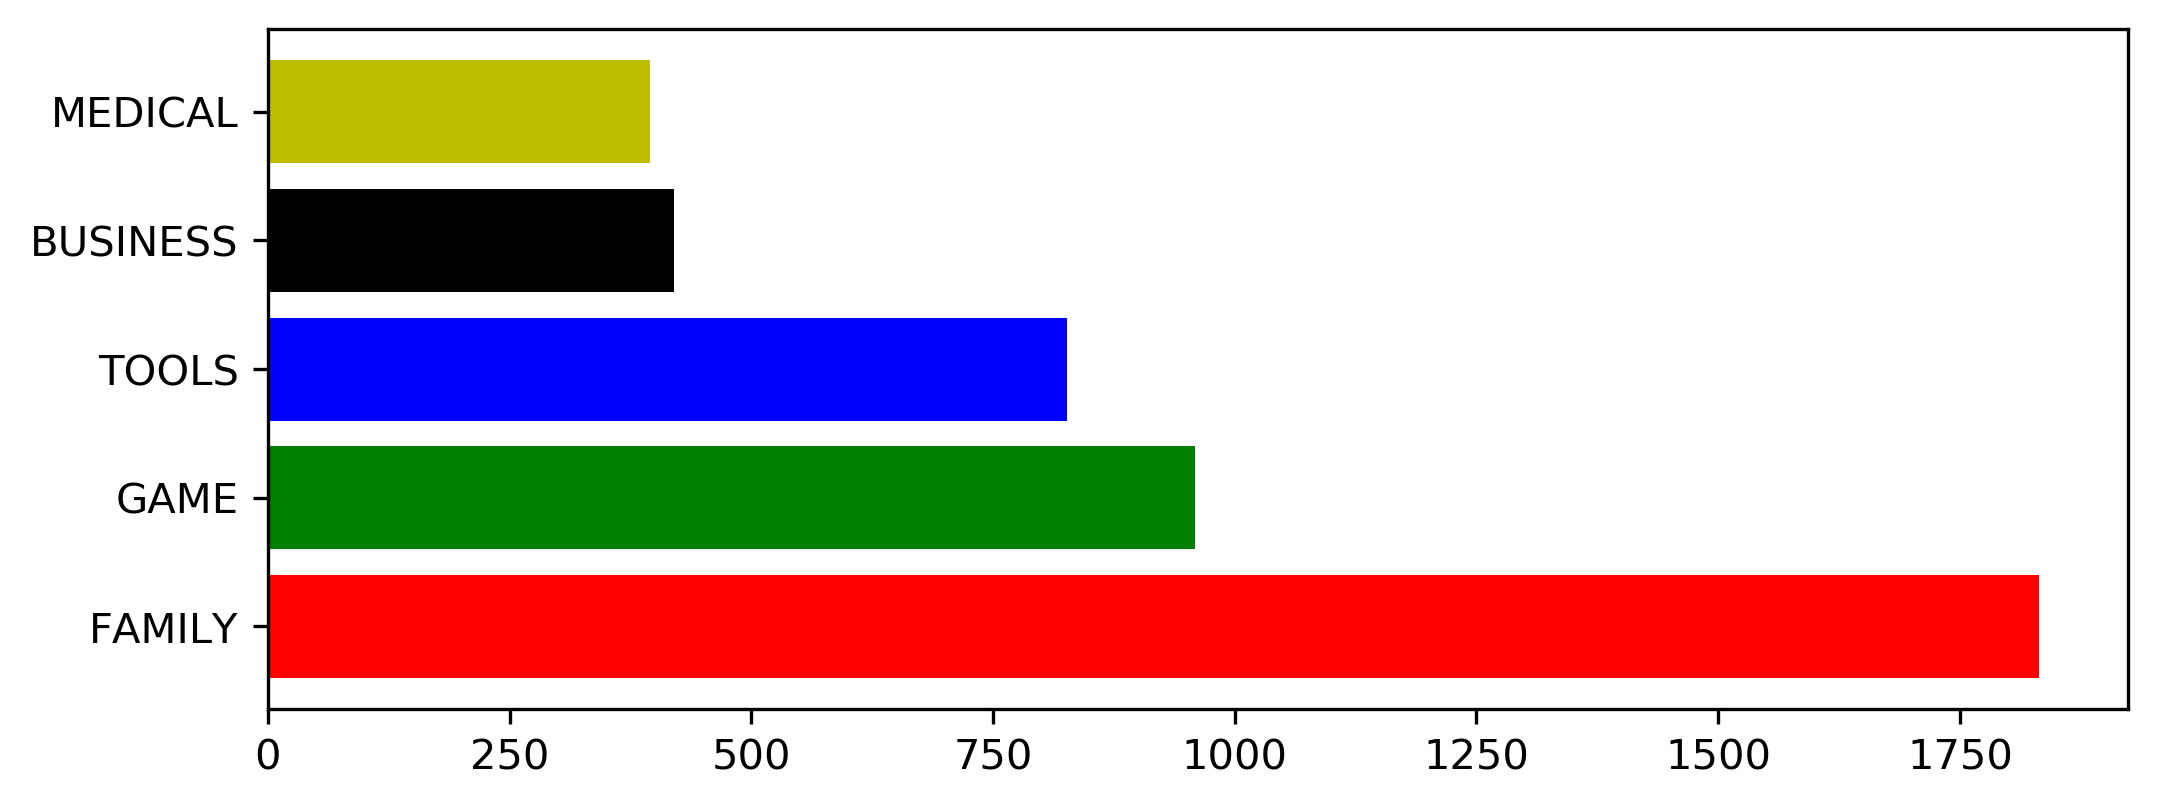

In [16]:
## BAR PLOT

# lengkapi tahap agregasi untuk membuat dataframe yang mengelompokkan aplikasi berdasarkan Category
# buatlah bar plot dimana axis x adalah nama Category dan axis y adalah jumlah aplikasi pada setiap kategori, kemudian urutkan dari jumlah terbanyak
cat_order = df2.groupby('Category').agg({
    'App' : 'count'
    }).rename({'Category':'Total'}, axis=1).sort_values(by='App', ascending=False).reset_index().head()
X = cat_order['Category']
Y = cat_order['App']
my_colors = 'rgbkymc'
# bagian ini digunakan untuk membuat kanvas/figure
fig = plt.figure(figsize=(8,3),dpi=300)
fig.add_subplot()
# bagian ini digunakan untuk membuat bar plot
# isi variabel x dan y yang telah di definisikan di atas
plt.barh(X, Y, color=my_colors)
# bagian ini digunakan untuk menyimpan plot dalam format image.png
plt.savefig('cat_order.png',bbox_inches="tight") 

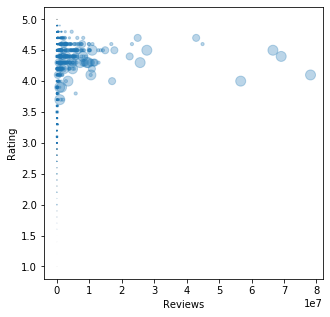

In [17]:
## SCATTER PLOT

# buatlah scatter plot untuk menampilkan hubungan dan persebaran aplikasi dilihat dari Review vs Rating
# ukuran scatter menggambarkan berapa banyak pengguna yang telah menginstall aplikasi 
X = playstore['Reviews'].values # axis x
Y = playstore['Rating'].values # axis y
area = playstore['Installs'].values/10000000 # ukuran besar/kecilnya lingkaran scatter plot
fig = plt.figure(figsize=(5,5))
fig.add_subplot()
# isi nama method untuk scatter plot, variabel x, dan variabel y
plt.scatter(x=X, y=Y, s=area, alpha=0.3)
plt.xlabel('Reviews')
plt.ylabel('Rating')
plt.savefig('rev_rat.png',bbox_inches="tight")

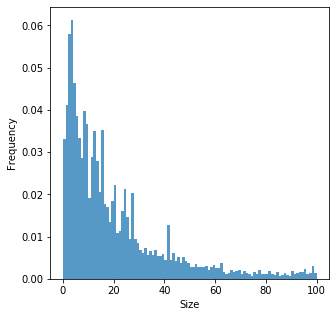

In [18]:
## HISTOGRAM SIZE DISTRIBUTION

# Buatlah sebuah histogram yang menggambarkan distribusi Size aplikasi dalam satuan Mb(Megabytes) 
# Histogram yang terbentuk terbagi menjadi 100 bins
X=(df2['Size']/1000000).values
fig = plt.figure(figsize=(5,5))
fig.add_subplot()
plt.hist(x=X, bins=100, density=True, alpha=0.75)
plt.xlabel('Size')
plt.ylabel('Frequency')
plt.savefig('hist_size.png',bbox_inches="tight")

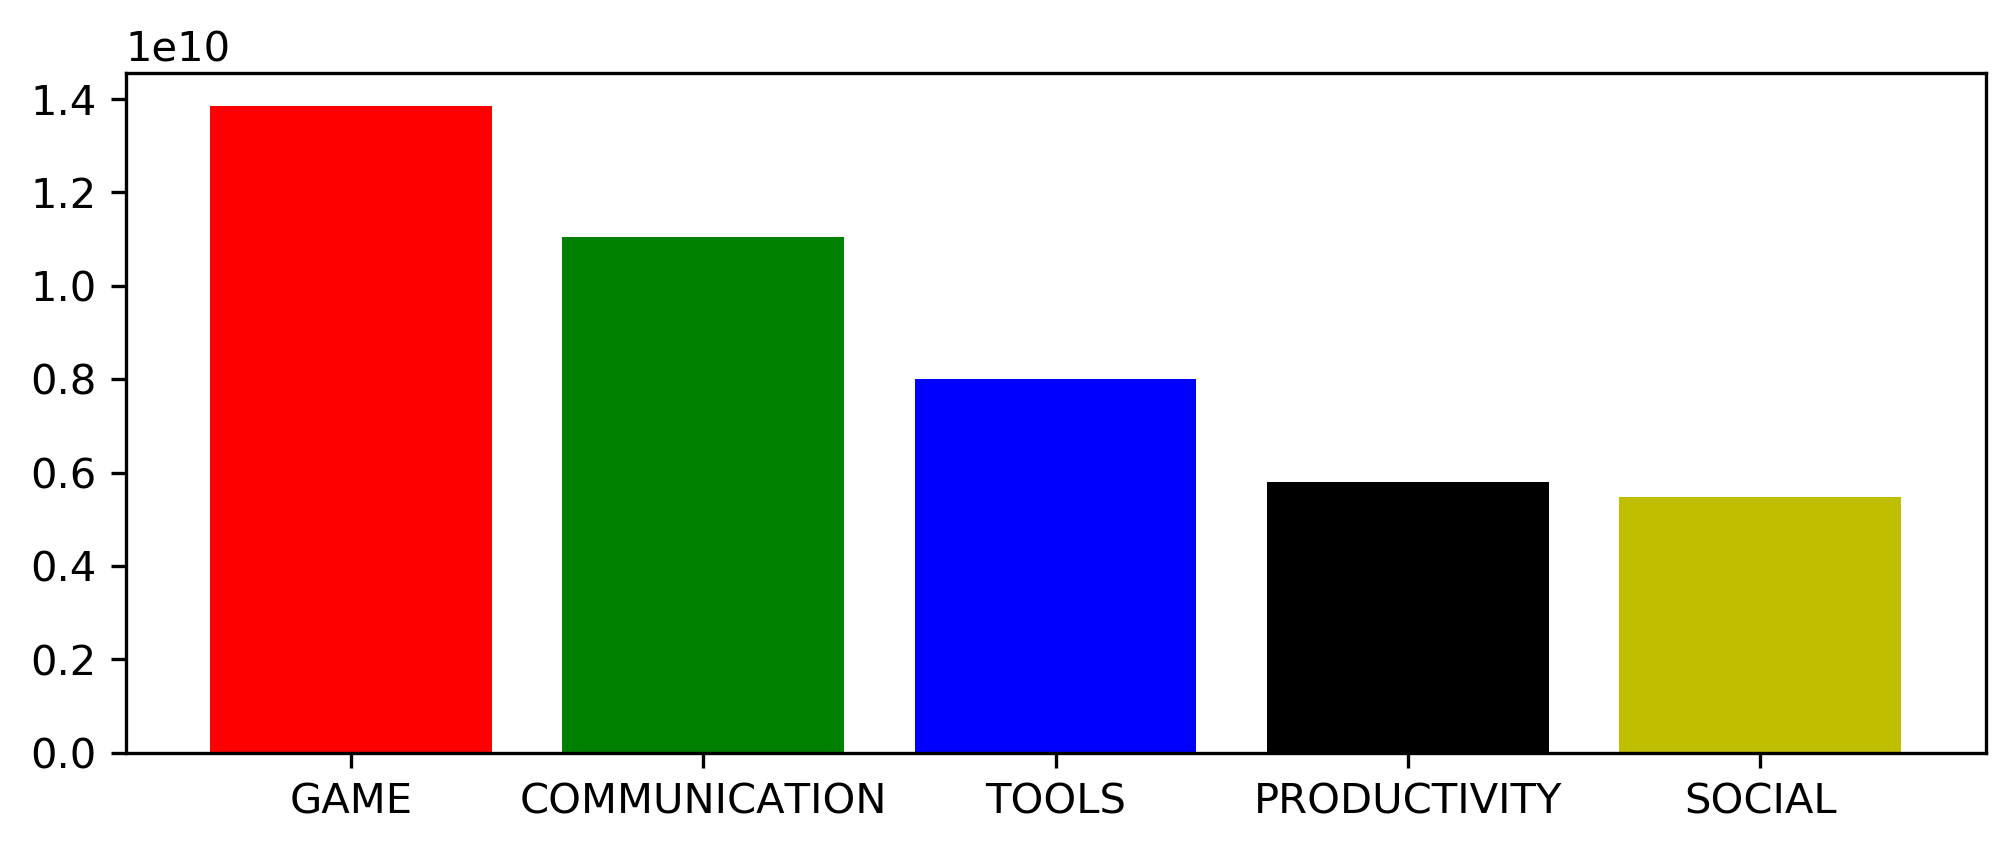

In [39]:
free_paid = pd.pivot_table(
    data=playstore,
    index='Category', 
    columns='Type', 
    values='Installs',
    aggfunc='sum',
    margins=True,
    margins_name='Total').sort_values(by='Total', ascending=False).reset_index().iloc[1:6, 0:3]
X = free_paid['Category']
Y = free_paid['Free']
my_colors = 'rgbkymc'
# bagian ini digunakan untuk membuat kanvas/figure
fig = plt.figure(figsize=(8,3),dpi=300)
fig.add_subplot()
# bagian ini digunakan untuk membuat bar plot
# isi variabel x dan y yang telah di definisikan di atas
plt.bar(X, Y, color=my_colors)
# bagian ini digunakan untuk menyimpan plot dalam format image.png
plt.savefig('free_paid.png',bbox_inches="tight")